# Using a trained reflectorch model

In the first subsection, we illustrate in detail the steps involved in the using a trained model (which resemble the steps performed during the training process, including the generation of synthetic data). 
In the second subsection, we show how to use the inference class, which abstracts away the implementation details, on experimental data.

## Detailed used of a reflectorch model on synthetic data

The first step is importing the necessary methods from the reflectorch package, as well as othar basic Python packages:

In [1]:
import torch
import matplotlib.pyplot as plt

from ipywidgets import interact
from reflectorch import get_trainer_by_name

torch.manual_seed(0); # set seed for reproducibility

In order to import a trained reflectorch model, we first have to specify the name of the trained model we wish to load. This name should match the name of the YAML configuration file used for training that model. Here we load a model for a 2-layer box parameterization of the thin film SLD profile.

In [2]:
trained_model_name = 'mc1'

Next, we initialize an instance of the `PointEstimatorTrainer` class using the `get_trainer_by_name` method.

:::{warning}
The `load_weights` argument must be set to `True` in order for the saved weights of the neural network to be loaded, otherwise the network weights are randomly initialized.
:::

In [3]:
trainer = get_trainer_by_name(config_name=trained_model_name, load_weights=True)

Model mc1 loaded. Number of parameters: 13.37 M


### Generating synthetic data

We can generate a batch of synthetic data using the `get_batch` method of the data loader:

In [4]:
batch_size = 64
simulated_data = trainer.loader.get_batch(batch_size=batch_size)

This method returns a dictionary with 4 entries indexed by the following keys:

 1. **params** - an instance of the `BasicParams` class containing the original (unscaled) values of the generated parameters, the generated minimum prior bound for each parameter and the generated maximum prior bound for each parameter (see the [paper](https://doi.org/10.1107/S1600576724002115) for more details about the generation process)
 2. **scaled_params** - a Pytorch Tensor containing the parameters, minimum bounds and maximum bounds, all scaled to the ML-friendly range [-1, 1]
 3. **q_values** - a Pytorch Tensor containing the reciprocal space (q) positions of the points in the reflectivity curve, in units of Å<sup>-1</sup>
 4. **scaled_noisy_curves** - a Pytorch Tensor containing the simulated reflectivity curves (including added noise) scaled to the ML-friendly range [-1, 1]

We can inspect some of the (scaled) simulated curves: 

(*interactive cursor not supported in the documentation*)

In [8]:
q = simulated_data['q_values']
scaled_noisy_curves = simulated_data['scaled_noisy_curves']
unscaled_noisy_curves = trainer.loader.curves_scaler.restore(scaled_noisy_curves)

@interact(i=(0, batch_size-1, 1))
def plot_refl_curve(i=0):
    
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel('q [$Å^{-1}$]', fontsize=24)
    ax.set_ylabel('R$_{scaled}$ (q)', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=15)
        
    ax.scatter(q[i].cpu().numpy(), scaled_noisy_curves[i].cpu().numpy(), c='blue', s=2.0)

interactive(children=(IntSlider(value=0, description='i', max=63), Output()), _dom_classes=('widget-interact',…

This trained model corresponds to a 2 layer (*in addition to the substrate*) parameterization of the SLD profile, which corresponds to 8 predicted film parameters:

In [14]:
n_layers = simulated_data['params'].max_layer_num
n_params = simulated_data['params'].num_params

print(f'Number of layers: {n_layers},  Number of film parameters: {n_params}')

Number of layers: 2,  Number of film parameters: 8


### Applying the model to synthetic data

The input to the neural network consists in the batch of reflectivity curves together with the prior bounds (minimum and maximum) for each film parameter. For experimental data, the prior bounds can be set according to the prior knowledge about the investigated thin film. In this example on simulated data, we use the prior bounds already sampled during the data generation process (i.e. meant for training the model) which ensures reasonable values for the prior bounds. 

In the `scaled_params` tensor the first 8 columns correspond to the *scaled* ground truth values of the film parameters, the next 8 columns to the *scaled* minimum bounds for the parameters and the last 8 to the *scaled* maximum bounds for the parameters. Thus, we select the last 16 columns as our input prior bounds:

In [15]:
scaled_bounds = simulated_data['scaled_params'][..., n_params:]

print(scaled_bounds.shape)

torch.Size([64, 16])


To obtain the input to the neural network, we concatenate the the reflectiviy curves with the prior bounds along the last axis of the tensor (`dim=-1`). We should also make sure that the input is of the `float` data type.

In [16]:
scaled_input = torch.cat([scaled_noisy_curves, scaled_bounds], dim=-1).float()

print(scaled_input.shape)

torch.Size([64, 144])


The neural network can be accessed as the `model` attribute of the trainer. By providing the previously constructed scaled input (reflectivity curves + prior bounds) to the network, we obtain the predictions for the parameters, scaled with respect to the prior bounds.

:::{note}
The neural network must be first set to evaluation mode, as this influences the functionality of some neural network components such as the batch normalization layers.
:::

In [17]:
with torch.no_grad():
    trainer.model.eval()
    
    scaled_predicted_params = trainer.model(scaled_input)
    
print(scaled_predicted_params.shape)

torch.Size([64, 8])


Now we need to restore the scaled predicted parameters to their unscaled (physical) values. Since the predicted parameters are scaled with respect to the input prior bounds, these are also required for the rescaling. We can concatenate the `scaled_predicted_params` and `scaled_bounds` tensors along the last tensor axis and provide them as input to the `restore_params` method of the prior sampler object (which can be accessed as `trainer.loader.prior_sampler`), the output being an instance of the `BasicParams` class.

In [18]:
restored_predictions = trainer.loader.prior_sampler.restore_params(torch.cat([scaled_predicted_params, scaled_bounds], dim=-1))
print(restored_predictions)

BasicParams(batch_size=64, max_layer_num=2, device=cuda:0)


The physical predictions can then be accessed using the corresponding attribute for each parameter type.

In [19]:
pred_idx = 0

print(f'Predicted thicknesses: {restored_predictions.thicknesses[pred_idx]}')
print(f'Predicted roughnesses: {restored_predictions.roughnesses[pred_idx]}')
print(f'Predicted layers SLDs: {restored_predictions.slds[pred_idx]}')

Predicted thicknesses: tensor([267.7688, 386.5402], device='cuda:0', dtype=torch.float64)
Predicted roughnesses: tensor([30.9099, 17.2008, 17.0507], device='cuda:0', dtype=torch.float64)
Predicted layers SLDs: tensor([ 7.2712, 23.1490, 36.2290], device='cuda:0', dtype=torch.float64)


Based on the predictions, we can easily simulate the corresponding reflectivity curves by using the `reflectivity` method of the previously obtained `BasicParams` object, which takes the q values as input:

In [20]:
predicted_curves = restored_predictions.reflectivity(q)

We can observe the input reflectivity curves alongside the curves corresponding to the neural network prediction. Additionally, we can print the prediction for each parameter alongside its ground truth value and its prior bounds.

In [21]:
from reflectorch import get_param_labels, get_density_profiles

#@interact(i=(0, batch_size-1, 1))
def plot_refl_curve(i=0):
    fig, ax = plt.subplots(1,2,figsize=(12,6))

    ax[0].set_yscale('log')
    ax[0].set_ylim(0.5e-10, 5)

    ax[0].set_xlabel('q [$Å^{-1}$]', fontsize=20)
    ax[0].set_ylabel('R(q)', fontsize=20)

    ax[0].tick_params(axis='both', which='major', labelsize=15)
    ax[0].tick_params(axis='both', which='minor', labelsize=15)
    
    y_tick_locations = [10**(-2*i) for i in range(6)]
    ax[0].yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
        
    ax[0].plot(q[i].cpu().numpy(), predicted_curves[i].cpu().numpy() + 1e-10, c='r', lw=1, label='prediction')
    ax[0].scatter(q[i].cpu().numpy(), unscaled_noisy_curves[i].cpu().numpy() + 1e-10, c='b', s=2, label='input sim. curve')

    ax[0].legend(loc='upper right', fontsize=14)

    z_axis = torch.linspace(-200, 1000, 1000, device='cuda')
    _, sld_profile_gt, _ = get_density_profiles(
         simulated_data['params'].thicknesses, 
         simulated_data['params'].roughnesses,
         simulated_data['params'].slds,
         z_axis)
    
    _, sld_profile_pred, _ = get_density_profiles(
         restored_predictions.thicknesses, 
         restored_predictions.roughnesses,
         restored_predictions.slds,
         z_axis)
    
    ax[1].plot(z_axis.cpu().numpy(), sld_profile_pred[i].cpu().numpy(), c='r', label='prediction')
    ax[1].plot(z_axis.cpu().numpy(), sld_profile_gt[i].cpu().numpy(), c='b', label='ground truth')

    ax[1].set_xlabel('z [$Å$]', fontsize=20)
    ax[1].set_ylabel('SLD [$10^{-6} Å^{-2}$]', fontsize=20)
    ax[1].tick_params(axis='both', which='major', labelsize=15)
    ax[1].tick_params(axis='both', which='minor', labelsize=15)

    plt.tight_layout()


    for l, t, p, min_b, max_b in zip(
          get_param_labels(n_layers),
          simulated_data['params'].parameters[i], 
          restored_predictions.parameters[i], 
          restored_predictions.min_bounds[i], 
          restored_predictions.max_bounds[i]
          ):
         print(f'{l.ljust(14)} --> True: {t:.2f} Predicted: {p:.2f}  Input prior bounds: ({min_b:.2f}, {max_b:.2f})')

Thickness L2   --> True: 189.28 Predicted: 200.55  Input prior bounds: (126.42, 230.66)
Thickness L1   --> True: 436.63 Predicted: 439.41  Input prior bounds: (124.63, 483.08)
Roughness L2   --> True: 18.21 Predicted: 18.65  Input prior bounds: (5.05, 33.49)
Roughness L1   --> True: 13.98 Predicted: 12.90  Input prior bounds: (3.72, 58.31)
Roughness sub  --> True: 20.10 Predicted: 21.09  Input prior bounds: (2.49, 50.91)
SLD L2         --> True: 5.09 Predicted: 4.56  Input prior bounds: (0.74, 5.45)
SLD L1         --> True: 9.08 Predicted: 8.52  Input prior bounds: (7.92, 10.62)
SLD sub        --> True: 34.77 Predicted: 34.72  Input prior bounds: (32.72, 35.74)


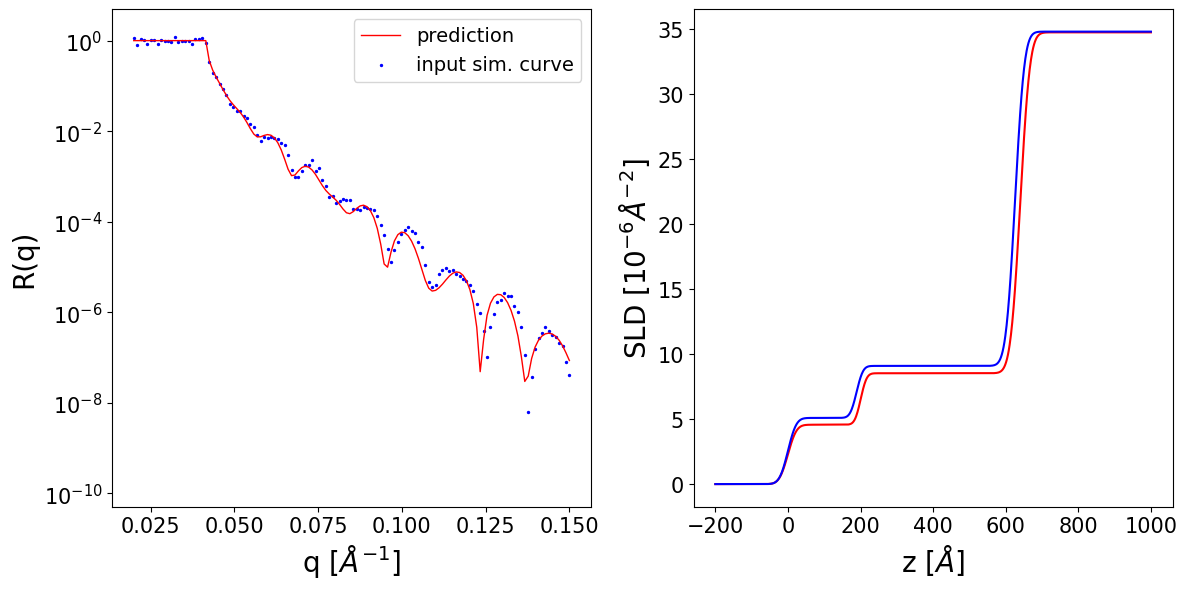

In [22]:
plot_refl_curve(i=15)

Thickness L2   --> True: 206.48 Predicted: 204.76  Input prior bounds: (54.91, 405.15)
Thickness L1   --> True: 77.36 Predicted: 77.76  Input prior bounds: (72.33, 98.73)
Roughness L2   --> True: 40.31 Predicted: 40.89  Input prior bounds: (16.38, 54.46)
Roughness L1   --> True: 26.28 Predicted: 25.56  Input prior bounds: (13.28, 31.51)
Roughness sub  --> True: 17.46 Predicted: 17.18  Input prior bounds: (9.69, 34.16)
SLD L2         --> True: 22.81 Predicted: 22.75  Input prior bounds: (20.52, 24.03)
SLD L1         --> True: 19.75 Predicted: 20.14  Input prior bounds: (19.57, 21.90)
SLD sub        --> True: 7.71 Predicted: 8.86  Input prior bounds: (7.11, 10.68)


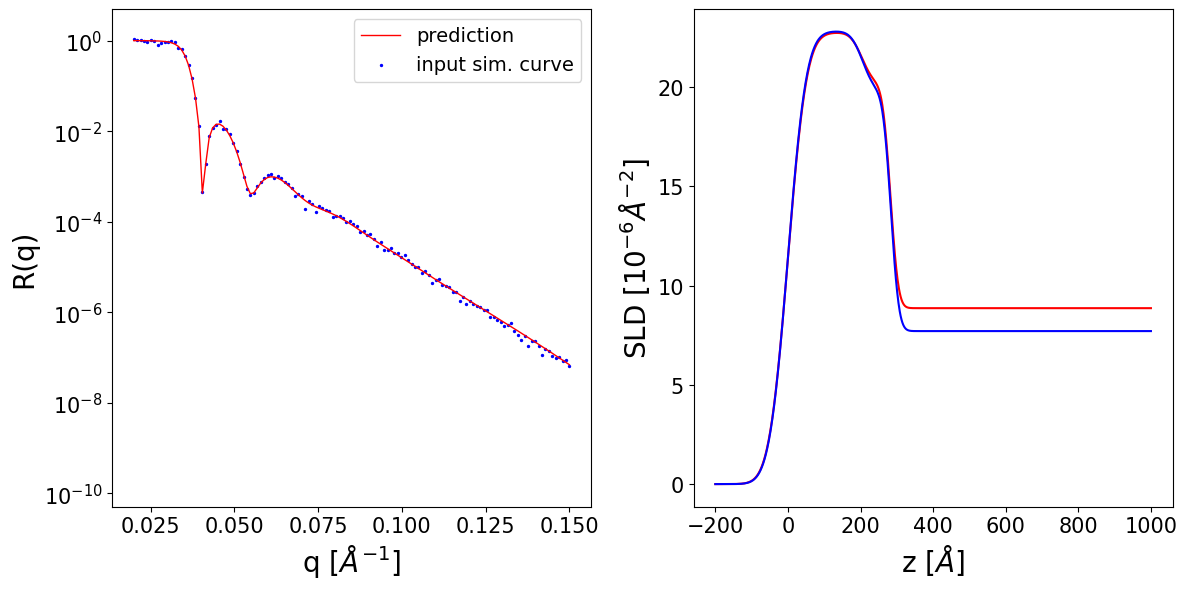

In [23]:
plot_refl_curve(i=30)

Thickness L2   --> True: 181.37 Predicted: 209.01  Input prior bounds: (12.05, 284.52)
Thickness L1   --> True: 347.88 Predicted: 348.13  Input prior bounds: (347.46, 348.64)
Roughness L2   --> True: 53.28 Predicted: 51.27  Input prior bounds: (42.37, 58.23)
Roughness L1   --> True: 4.53 Predicted: 4.19  Input prior bounds: (2.63, 9.84)
Roughness sub  --> True: 21.87 Predicted: 21.86  Input prior bounds: (17.86, 22.75)
SLD L2         --> True: 22.55 Predicted: 22.40  Input prior bounds: (21.77, 26.07)
SLD L1         --> True: 44.41 Predicted: 44.66  Input prior bounds: (44.14, 44.89)
SLD sub        --> True: 12.72 Predicted: 14.00  Input prior bounds: (12.72, 15.42)


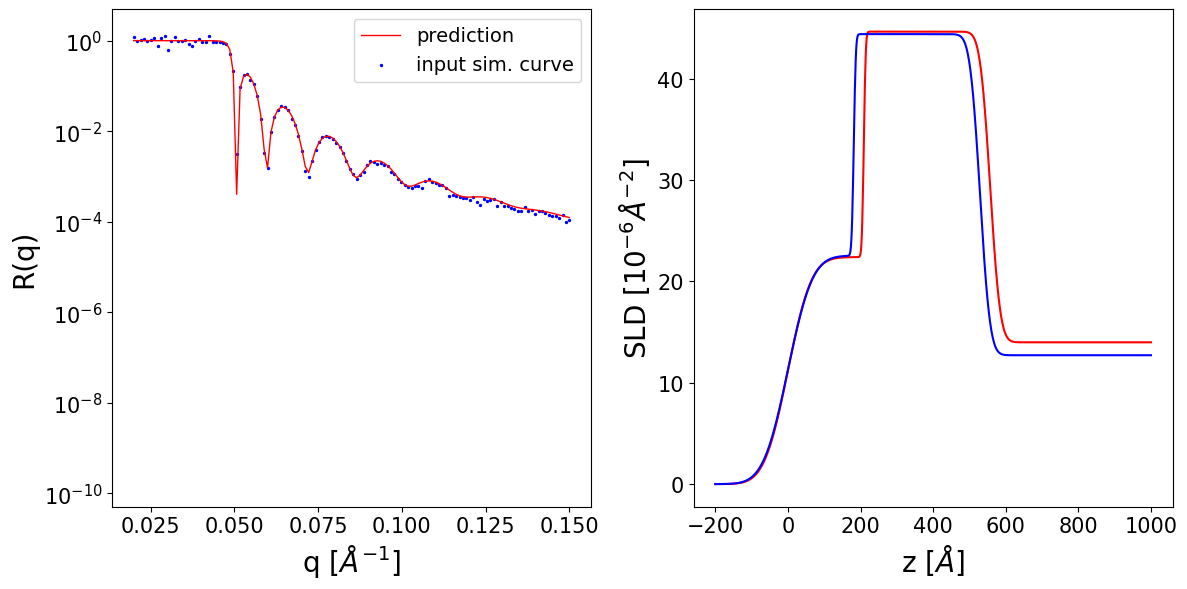

In [24]:
plot_refl_curve(i=45)

## Simplified use of a trained reflectorch model on experimental data

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from reflectorch import EasyInferenceModel, interp_reflectivity, get_param_labels

torch.manual_seed(0); # set seed for reproducibility

The `EasyInferenceModel` class simplifies the inference step for single reflectivity curves. We initialize the inference model by providing the name of the configuration file of a pretrained model (`config_name`), either with or without the '.yaml' extension. By default, the file name of the saved model weights for a specific configuration has the format 'model_' + config_name + '.pt', but a different file name can be specified via the `model_name` argument. The `root_dir` argument can be used to specify a project directory containing the `configs` and `saved_models` subdirectories (containing the configurations and model weights, respectively), if different from the default package directory. If the configuration or weights files are not found locally, they can be downloaded automatically from the Huggingface repository specified with the `repo_id` argument. Additionally, the `device` argument can be set to either `cuda` (for inference on the GPU) or `cpu` (for computers without a GPU with CUDA support).

In [11]:
inference_model = EasyInferenceModel(config_name='mc25',
                                     model_name=None,
                                     root_dir=None,
                                     repo_id='valentinsingularity/reflectivity',
                                     device='cuda',
                                     )

Configuration file `/home/vmunteanu/Jupyter Notebooks/Reflectivity/reflectorch/configs/mc25.yaml` found locally.
Weights file `/home/vmunteanu/Jupyter Notebooks/Reflectivity/reflectorch/saved_models/model_mc25.pt` found locally.
Model mc25 loaded. Number of parameters: 13.37 M
The model corresponds to a parameterization with 2 layers (8 predicted parameters)
Parameter types and total ranges: {'thicknesses': [0.0, 500.0], 'roughnesses': [0.0, 20.0], 'slds': [0.0, 50.0]}
Allowed widths of the prior bound intervals (max-min): {'thicknesses': [0.01, 500.0], 'roughnesses': [0.01, 20.0], 'slds': [0.01, 5.0]}
The model was trained on curves discretized at 128 uniform points between between q_min=0.02 and q_max=0.15


We consider the following reflectivity curve (already preprocessed by standard procedures):

In [12]:
loaded_data_dict = torch.load('../exp_data/data_PTCDI-C3.pt')
curve_exp = loaded_data_dict['curves'][0]
q_exp = loaded_data_dict['q'][0]

print(curve_exp.shape, q_exp.shape, q_exp.min(), q_exp.max())

(141,) (141,) 0.014236805785361413 0.21345664393805258


We interpolate the reflectivity curve to the q points the model was trained on:

In [13]:
q_model = inference_model.trainer.loader.q_generator.q.cpu().numpy()
exp_curve_interp = interp_reflectivity(q_model, q_exp, curve_exp)

print(exp_curve_interp.shape)

(128,)


This is a measurement for a two-layer film in which we have some prior knowlede about the investigated system. We know the substrate is silicon on top of which sits a thin silicon oxide layer, followed by a perylene diimide (PTCDI-C3) layer. Thus, we can set narrow prior bounds for the scattering length densities (around known value for these materials) and for the thickness of the silicon oxide layer, but we set wide prior bounds for the roughnesses and for the thickness of the perylene diimide layer. We specify the prior bounds for the parameters as a list of tuples `(min_prior_bound, max_prior_bound)`. 

In [14]:
prior_bounds = [(1., 400.), (1., 10.), #layer thicknesses (top to bottom)
                (0., 20.), (0., 15.), (0., 15.), #interlayer roughnesses (top to bottom)
                (10., 13.), (20.,21.), (20., 21.)] #real layer slds (top to bottom)

Now, we can call the `predict` method of the inference model and provide as input the reflectivity curve, the q values and the prior bounds in order to obtain the neural network predictions. If the `clip_prediction` argument is `True`, the predictions are clipped to ensure they are not outside the interval defined by the prior bounds. If the `polish_prediction` argument is `True`, the predictions are further polished using a conventional least mean squares (LMS) fit. The method returns a dictionary containing the predicted parameters (both as a BasicParams object and as a Numpy array). If `calc_pred_curve` is `True`, the reflectivity curve corresponding to the predicted parameters is also computed and added to the dictionary.

(*alpha functionality*): Alternatively, by calling the method `predict_using_widget` (in a Jupyter Notebook), one can make use of an interactive widget for selecting the minimum and maximum prior bound for each parameter, either by moving the sliders or typing in the values in the box on the right side. The range of each slider corresponds to the training range for that specific parameter, also the width of the selected interval can not exceed the prior bound width used for that parameter during training.

```python
prediction_dict = inference_model.predict_using_widget(reflectivity_curve=exp_curve_interp, q_values=q_model)
```

In [15]:
prediction_dict = inference_model.predict(reflectivity_curve=exp_curve_interp,
                                          q_values=q_model,
                                          prior_bounds=prior_bounds,
                                          clip_prediction=False,
                                          polish_prediction=True,
                                          calc_pred_curve=True,
                                          )
print(prediction_dict.keys())


pred_params = prediction_dict['predicted_params_array']
pred_curve = prediction_dict['predicted_curve']

dict_keys(['predicted_params_object', 'predicted_params_array', 'param_names', 'predicted_curve', 'polished_params_array', 'polished_curve'])


In [16]:
n_layers = inference_model.trainer.loader.prior_sampler.max_num_layers
for param_name, pred_param_val, polished_param_val in zip(prediction_dict["param_names"], pred_params, prediction_dict["polished_params_array"]):
        print(f'{param_name.ljust(14)} -> Predicted: {pred_param_val:.2f}       Polished: {polished_param_val:.2f}')

Thickness L2   -> Predicted: 194.77       Polished: 194.77
Thickness L1   -> Predicted: 13.28       Polished: 13.28
Roughness L2   -> Predicted: 19.61       Polished: 19.61
Roughness L1   -> Predicted: 4.74       Polished: 4.74
Roughness sub  -> Predicted: 8.11       Polished: 8.11
SLD L2         -> Predicted: 10.87       Polished: 10.87
SLD L1         -> Predicted: 20.43       Polished: 20.43
SLD sub        -> Predicted: 20.37       Polished: 20.37


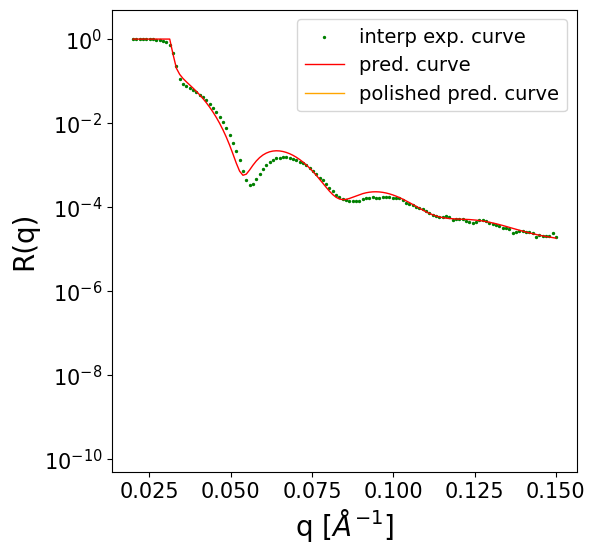

In [17]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_yscale('log')
ax.set_ylim(0.5e-10, 5)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
    
ax.scatter(q_model, exp_curve_interp, c='g', s=2, label='interp exp. curve')
ax.plot(q_model, pred_curve, c='r', lw=1, label='pred. curve')
ax.plot(q_model, prediction_dict['polished_curve'], c='orange', lw=1, label='polished pred. curve')

ax.legend(loc='upper right', fontsize=14);

Now we make a prediction for a similar structure, except that the top layer is fullerene (C60) instead. Thus we only change the prior bounds for the SLD of this layer.

Thickness L2   : 159.77
Thickness L1   : 12.37
Roughness L2   : 8.89
Roughness L1   : 3.97
Roughness sub  : 5.79
SLD L2         : 15.09
SLD L1         : 20.80
SLD sub        : 20.06


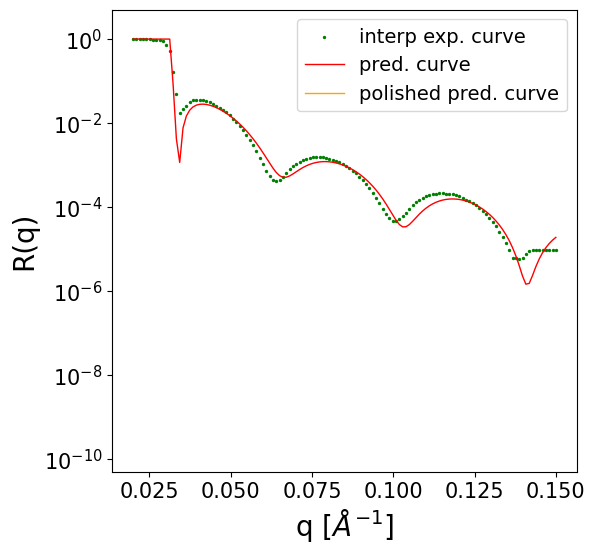

In [18]:
loaded_data_dict = torch.load('../exp_data/data_C60.pt')
curve_exp = loaded_data_dict['curves'][0]
q_exp = loaded_data_dict['q'][0]

q_model = inference_model.trainer.loader.q_generator.q.cpu().numpy()
exp_curve_interp = interp_reflectivity(q_model, q_exp, curve_exp)

#print(curve_exp.shape, q_exp.shape, q_exp.min(), q_exp.max())

prior_bounds = [(1., 400.), (1., 10.), #layer thicknesses (top to bottom)
                (0., 20.), (0., 15.), (0., 15.), #interlayer roughnesses (top to bottom)
                (13., 18.), (20.,21.), (20., 21.)] #real layer slds (top to bottom)

prediction_dict = inference_model.predict(reflectivity_curve=exp_curve_interp,
                                          q_values=q_model,
                                          prior_bounds=prior_bounds,
                                          clip_prediction=False,
                                          polish_prediction=True,
                                          calc_pred_curve=True,
                                          )


pred_params = prediction_dict['predicted_params_array']
pred_curve = prediction_dict['predicted_curve']

n_layers = inference_model.trainer.loader.prior_sampler.max_num_layers
for param_name, param_val in zip(prediction_dict["param_names"], pred_params):
        print(f'{param_name.ljust(14)} : {param_val:.2f}')

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_yscale('log')
ax.set_ylim(0.5e-10, 5)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
    
ax.scatter(q_model, exp_curve_interp, c='g', s=2, label='interp exp. curve')
ax.plot(q_model, pred_curve, c='r', lw=1, label='pred. curve')
ax.plot(q_model, prediction_dict['polished_curve'], c='orange', lw=1, label='polished pred. curve')

ax.legend(loc='upper right', fontsize=14);

Above, we used a model trained with a fixed q discretization (i.e. 1D CNN embedding network) and interpolated the experimental reflectivity curves to that specific discretization. Now we try to predict using using a model trained with a variable q discretization (i.e. FNO embedding network) without interpolating the reflectivity curves.

In [19]:
inference_model = EasyInferenceModel(config_name='mc-o4')

Configuration file `/home/vmunteanu/Jupyter Notebooks/Reflectivity/reflectorch/configs/mc-o4.yaml` found locally.
Weights file `/home/vmunteanu/Jupyter Notebooks/Reflectivity/reflectorch/saved_models/model_mc-o4.pt` found locally.
Model mc-o4 loaded. Number of parameters: 14.61 M
The model corresponds to a parameterization with 2 layers (8 predicted parameters)
Parameter types and total ranges: {'thicknesses': [0.0, 500.0], 'roughnesses': [0.0, 20.0], 'slds': [0.0, 50.0]}
Allowed widths of the prior bound intervals (max-min): {'thicknesses': [0.01, 500.0], 'roughnesses': [0.01, 20.0], 'slds': [0.01, 5.0]}
The model was trained on curves discretized at a number between 128 and 256 of uniform points between between q_min in [0.01, 0.05] and q_max in [0.15, 0.4]


Thickness L2   : 186.60
Thickness L1   : 8.87
Roughness L2   : 19.92
Roughness L1   : 3.64
Roughness sub  : 5.71
SLD L2         : 11.17
SLD L1         : 20.33
SLD sub        : 20.53


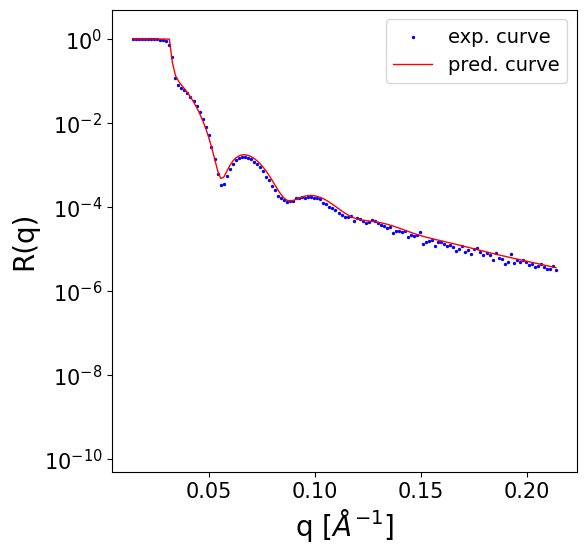

In [20]:
loaded_data_dict = torch.load('../exp_data/data_PTCDI-C3.pt')
curve_exp = loaded_data_dict['curves'][0]
q_exp = loaded_data_dict['q'][0]

#print(curve_exp.shape, q_exp.shape, q_exp.min(), q_exp.max())

prior_bounds = [(1., 400.), (1., 10.), #layer thicknesses (top to bottom)
                (0., 20.), (0., 15.), (0., 15.), #interlayer roughnesses (top to bottom)
                (10., 13.), (20.,21.), (20., 21.)] #real layer slds (top to bottom)

prediction_dict = inference_model.predict(reflectivity_curve=curve_exp,
                                          q_values=q_exp,
                                          prior_bounds=prior_bounds,
                                          clip_prediction=False,
                                          polish_prediction=True,
                                          calc_pred_curve=True,
                                          )


pred_params = prediction_dict['predicted_params_array']
pred_curve = prediction_dict['predicted_curve']

n_layers = inference_model.trainer.loader.prior_sampler.max_num_layers
for param_name, param_val in zip(prediction_dict["param_names"], pred_params):
        print(f'{param_name.ljust(14)} : {param_val:.2f}')

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_yscale('log')
ax.set_ylim(0.5e-10, 5)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
    
ax.scatter(q_exp, curve_exp, c='b', s=2, label='exp. curve')
ax.plot(q_exp, pred_curve, c='r', lw=1, label='pred. curve')
#ax.plot(q_exp, prediction_dict['polished_curve'], c='orange', lw=1, label='polished pred. curve')

ax.legend(loc='upper right', fontsize=14);

Thickness L2   : 159.50
Thickness L1   : 10.19
Roughness L2   : 7.18
Roughness L1   : 5.03
Roughness sub  : 8.91
SLD L2         : 14.32
SLD L1         : 20.57
SLD sub        : 20.10


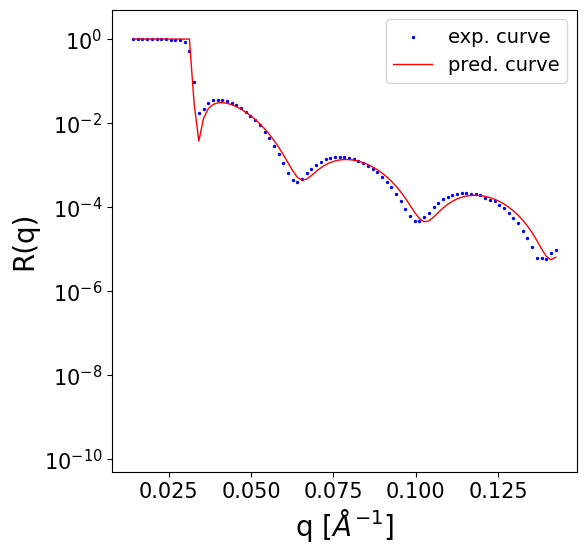

In [21]:
loaded_data_dict = torch.load('../exp_data/data_C60.pt')
curve_exp = loaded_data_dict['curves'][0]
q_exp = loaded_data_dict['q'][0]

#print(curve_exp.shape, q_exp.shape, q_exp.min(), q_exp.max())

prior_bounds = [(1., 400.), (1., 10.), #layer thicknesses (top to bottom)
                (0., 20.), (0., 15.), (0., 15.), #interlayer roughnesses (top to bottom)
                (13., 18.), (20.,21.), (20., 21.)] #real layer slds (top to bottom)

prediction_dict = inference_model.predict(reflectivity_curve=curve_exp,
                                          q_values=q_exp,
                                          prior_bounds=prior_bounds,
                                          clip_prediction=False,
                                          polish_prediction=True,
                                          calc_pred_curve=True,
                                          )


pred_params = prediction_dict['predicted_params_array']
pred_curve = prediction_dict['predicted_curve']

n_layers = inference_model.trainer.loader.prior_sampler.max_num_layers
for param_name, param_val in zip(prediction_dict["param_names"], pred_params):
        print(f'{param_name.ljust(14)} : {param_val:.2f}')

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.set_yscale('log')
ax.set_ylim(0.5e-10, 5)
ax.set_xlabel('q [$Å^{-1}$]', fontsize=20)
ax.set_ylabel('R(q)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
y_tick_locations = [10**(-2*i) for i in range(6)]
ax.yaxis.set_major_locator(plt.FixedLocator(y_tick_locations))
    
ax.scatter(q_exp, curve_exp, c='b', s=2, label='exp. curve')
ax.plot(q_exp, pred_curve, c='r', lw=1, label='pred. curve')
#ax.plot(q_exp, prediction_dict['polished_curve'], c='orange', lw=1, label='polished pred. curve')

ax.legend(loc='upper right', fontsize=14);